## 要約生成

### データセット

#### データセットのダウンロード

In [1]:
from datasets import load_dataset

# データセットを読み込む
dataset = load_dataset("llm-book/livedoor-news-corpus")

Using custom data configuration default


Dataset livedoor-news-corpus downloaded and prepared to /root/.cache/huggingface/datasets/llm-book___livedoor-news-corpus/default/0.0.0/0e68df407299550ef5ff2e77547963ebf3cb31cdf6cb53be6ab1aac47965d5dd. Subsequent calls will reuse this data.


100%|██████████| 3/3 [00:00<00:00, 1237.87it/s]


In [2]:
# データセットの形式と事例数を表示する
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['url', 'date', 'title', 'content', 'category'],
        num_rows: 5893
    })
    validation: Dataset({
        features: ['url', 'date', 'title', 'content', 'category'],
        num_rows: 736
    })
    test: Dataset({
        features: ['url', 'date', 'title', 'content', 'category'],
        num_rows: 738
    })
})


In [3]:
from pprint import pprint

# 訓練セットの最初の2つの事例を表示する
pprint(list(dataset["train"])[:2])

[{'category': 'livedoor-homme',
  'content': '日常の何気ない気持ちをTwitterにつぶやいたり、実名登録のFacebookで懐かしい友人と再会したり、SNSはもはや我々の生活において欠かせない存在となりつつある。先日、国内の月間利用者数が1,000万人を突破し、mixi（1,520万人、2011年12月現在）を追い抜くのも時間の問題と思われるFacebookでは、診断やゲームなど様々なアプリが生まれ、ユーザーのタイムラインを今日も賑わしている。しかし、その一方で、Facebookを悪用するケースもまた徐々に増え始めている。  '
             'Facebookでは、2008年1月にAPIが公開されて以来、様々なアプリが誕生しているが、同年8月にはボット型の不正プログラム「KOOBFACE」が確認され、感染を広げた。その手口とは、「あなたがビデオに出ていますよ！」というメッセージが届き、YouTubeに偽装したURLにアクセスすると、動画再生のためにプログラムのインストールを求められ、不正プログラムをダウンロードさせるというもの。  '
             '不正プログラムには、画面に偽の感染警告を表示し、駆除のための偽セキュリティソフトを購入させ、クレジットカード情報などの個人情報を盗むものや、ブラウザでログイン時のアカウント情報を盗むものなどが存在。更に、そのユーザーのFacebookフレンド宛にも不正なメッセージを自動送信することによって、感染規模を拡大していくのだ。  '
             '2010年12月にはFacebookの公式アカウントを騙り、不正プログラムをインストールさせようとするスパムメールや、2011年1月にはアカウントの更新に必要として、個人情報を盗むフィッシングサイトを確認。その他にも、可愛らしい女性のプロフィール画像を載せた人物から好意的なメッセージが届き、携帯アドレスへの連絡を求めるスパムメッセージなど、その手口は年々多様化している。  '
             'Facebookのみならず、今年1月にはTwitter公式アカウントを騙るフィッシング詐欺サイトも確認され、昨年12月の警察庁による発表では、SNS以外にもフィッシング詐欺で約2,000万円、不正

#### データセットの分析

In [4]:
from collections import Counter

# 各カテゴリの事例数を確認する
pprint(Counter(dataset["train"]["category"]).most_common())

[('sports-watch', 731),
 ('it-life-hack', 718),
 ('dokujo-tsushin', 695),
 ('smax', 690),
 ('movie-enter', 689),
 ('peachy', 677),
 ('kaden-channel', 656),
 ('topic-news', 616),
 ('livedoor-homme', 421)]


In [6]:
categories = set() # カテゴリの集合
for data in dataset["train"]: # 訓練セットの各事例を処理する
    category, title = data["category"], data["title"]
    # すでに出現しているカテゴリはスキップ
    if category not in categories:
        categories.add(category)
        print(f"{category}: {title}")

livedoor-homme: 急成長を遂げるFacebookに忍び寄る影
it-life-hack: いつでもどこでも自分専用環境！　Ubuntu起動ができるUSBメモリーを作成！【デジ通】
kaden-channel: 「PS Vita」がついに発売　—　初日は待ちわびたファンが行列を作る大盛況【話題】
smax: ソニーモバイル、Xperia ionのLTE非対応版「Xperia ion HSPA」を発表
peachy: 【終了しました】リムジンでお買い物の後はスイートルームで“うっとろりん”、お姫さまのような1日をプレゼント
movie-enter: 有言実行の男、ジュード・ロウが自信作を引っ提げ来日決定
dokujo-tsushin: 言いにくい「芸能人の○○みたいにして」の一言
sports-watch: 日本代表敗戦、セルジオ越後氏は「ベストメンバーでなければこの程度」
topic-news: 「柏木はブタ鼻」嫉妬ややっかみからAKB48で流行るイジメごっこ


In [9]:
# !pip install japanize-matplotlib

100%|██████████| 5893/5893 [00:08<00:00, 705.11it/s]


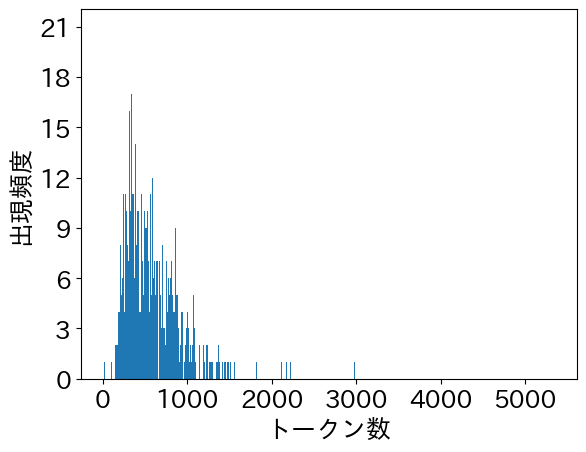

100%|██████████| 5893/5893 [00:01<00:00, 5200.62it/s]


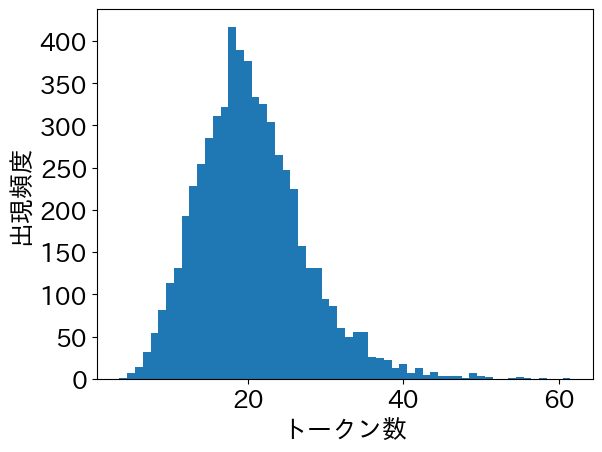

In [14]:
from collections import Counter
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from tqdm import tqdm
from transformers import AutoTokenizer, PreTrainedTokenizer
import japanize_matplotlib

# フォントサイズ変更
plt.rcParams["font.size"] = 18

def visualize_num_tokens_distribution(
    dataset: Dataset,
    tokenizer: PreTrainedTokenizer,
    column: str
) -> None:
    """トークン数の分布を可視化"""
    # 各事例でトークン数をカウントし、トークン数毎に結果を集約する
    counter = Counter()
    for data in tqdm(dataset):
        num_tokens = len(tokenizer.tokenize(data[column]))
        counter[num_tokens] += 1
        
    # トークン数の分布を可視化
    plt.bar(counter.keys(), counter.values(), width=1.0)
    plt.xlabel("トークン数")
    plt.ylabel("出現頻度")
    plt.gca().yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter("%d"))
    plt.show()
    
# トークナイザを読み込む
model_name = "retrieva-jp/t5-base-long"
tokenizer = AutoTokenizer.from_pretrained(model_name)
# 記事のトークン数の分布を可視化する
visualize_num_tokens_distribution(
    dataset["train"], tokenizer, "content"
)
# 見出しのトークン数の分布を可視化する
visualize_num_tokens_distribution(
    dataset["train"], tokenizer, "title"
)

### 評価指標

In [15]:
!pip install mecab-python3 rouge-score sacrebleu bert_score

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.7/581.7 kB 7.0 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 16.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 29.2 MB/s eta 0:00:00a 0:00:01
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24954 sha256=f1e4ab784ade7ab346a798edb519d562309d0c5

#### ROUGE

In [16]:
reference = "日本語T5モデルの公開"
prediction1 = "T5モデルの日本語版を公開"
prediction2 = "日本語T5をリリース"
prediction3 = "Japanese T5を発表"

In [17]:
import ipadic
import MeCab

# IPAdicを用いたMeCabを使用して、単語分割を行う
tagger = MeCab.Tagger(f"-O wakati {ipadic.MECAB_ARGS}")
ref_wakati = tagger.parse(reference).strip()
pred_wakati1 = tagger.parse(prediction1).strip()
pred_wakati2 = tagger.parse(prediction2).strip()
pred_wakati3 = tagger.parse(prediction3).strip()
print(f"参照文: {ref_wakati}")
print(f"生成文1: {pred_wakati1}")
print(f"生成文2: {pred_wakati2}")
print(f"生成文3: {pred_wakati3}")

参照文: 日本語 T 5 モデル の 公開
生成文1: T 5 モデル の 日本語 版 を 公開
生成文2: 日本語 T 5 を リリース
生成文3: Japanese T 5 を 発表


In [29]:
### ROUGEを算出
from collections import defaultdict
import pandas as pd
from datasets import load_metric

# pandasの小数点以下の桁数を設定
pd.options.display.precision = 3

def convert_words_to_ids(
    predictions: list[str],
    references: list[str]
) -> tuple[list[str], list[str]]:
    """単語列をID列に変換"""
    # 単語にユニークなIDを割りあてるためのdefaultdictを作成
    word2id = defaultdict(lambda: len(word2id))
    
    # 単語区切りの文字列をID大文字に変換する
    pred_ids = [
        " ".join([str(word2id[w]) for w in p.split()])
        for p in predictions
    ]
    ref_ids = [
        " ".join([str(word2id[w]) for w in r.split()])
        for r in references
    ]
    return pred_ids, ref_ids

def compute_rouge(
    predictions: list[str],
    references: list[str]
) -> dict[str, dict[str, float]]:
    """ROUGEを算出"""
    # ROUGEをロードする
    rouge = load_metric("rouge")
    # 単語列をID列に変換する
    pred_ids, ref_ids = convert_words_to_ids(predictions, references)
    # 単語ID列を評価対象に加える
    rouge.add_batch(predictions=pred_ids, references=ref_ids,)
    # ROUGEスコアを計算する
    scores = rouge.compute(rouge_types=["rouge1", "rouge2", "rougeL"])
    return {k: v.mid for k,v in scores.items()}

# ROUGEを算出した結果を表示する
rouge_results = {
    "生成文1": compute_rouge([pred_wakati1], [ref_wakati]),
    "生成文2": compute_rouge([pred_wakati2], [ref_wakati]),
    "生成文3": compute_rouge([pred_wakati3], [ref_wakati])
}
df_list = [
    pd.DataFrame.from_dict(rouge_results[k], orient="index")
    for k in rouge_results.keys()
]
display(pd.concat(df_list, keys=rouge_results.keys(), axis=1).T)

rouge1  rouge2  rougeL
生成文1 precision   0.750   0.429   0.625
     recall      1.000   0.600   0.833
     fmeasure    0.857   0.500   0.714
生成文2 precision   0.600   0.500   0.600
     recall      0.500   0.400   0.500
     fmeasure    0.545   0.444   0.545
生成文3 precision   0.400   0.250   0.400
     recall      0.333   0.200   0.333
     fmeasure    0.364   0.222   0.364